In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle
from matplotlib.animation import FuncAnimation 


import tensorflow
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, Flatten, MaxPooling1D, Conv1D, GlobalAveragePooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

dotrain = True
dotest = True
doanim = False

epochs = 500
batch_size = 32

dense_numunits = 16
conv1d_numunits = 32
simplernn_numunits = 16
lstm_numunits = 16

history_length = 6
forecast_length = 24

np.random.seed(237)
tensorflow.random.set_seed(237)

In [8]:
def build_window(data, h, f):
    
    dataX, dataY = [], []
    
    for i in range(len(data)-h-f):
        dataX.append(data[i:(i+h)])
        dataY.append(data[(i+h):(i+h+f)])
        
    dataX = np.array(dataX)
    dataX = np.reshape(dataX, (dataX.shape[0], 1, dataX.shape[1]))
    
    dataY = np.array(dataY)
    
    return dataX, dataY

# Load data

In [9]:
Y = pd.DataFrame()

folder = '/home/gomes/Dropbox/gabriel/work/teaching/mine/emeritus/week23_NN_II/code/traffic/'

prefix = '2018/flow_station_1209204_2018_'
for i in range(1,12):
    filename = '{}{}{:02d}'.format(folder,prefix,i)
    with open(filename,'rb') as f:
        X = pickle.load(f)
        X.set_index(pd.to_datetime(X['Timestamp']),inplace=True)
        X.drop(columns=['Timestamp'],inplace=True)
        Y = Y.append(X)
        
prefix = '2019/flow_station_1209204_2019_'
for i in range(1,12):
    filename = '{}{}{:02d}'.format(folder,prefix,i)
    with open(filename,'rb') as f:
        X = pickle.load(f)
        X.set_index(pd.to_datetime(X['Timestamp']),inplace=True)
        X.drop(columns=['Timestamp'],inplace=True)
        Y = Y.append(X)
        
raw_data = Y['Total Flow'].values
data = raw_data

# Scale the data

In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))
raw_data = scaler.fit_transform(raw_data.reshape(-1, 1))

Text(0.5, 0, 'Hours')

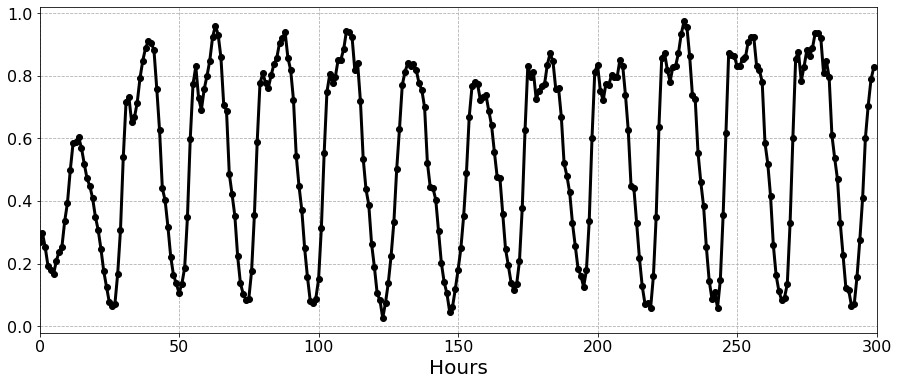

In [11]:
plt.figure(figsize=(15,6))
plt.plot(raw_data[:300],'ko-',linewidth=3)
plt.grid(linestyle='--')
plt.xlim(0,300)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Hours',fontsize=20)
# plt.ylabel('MSE',fontsize=20,rotation=0, labelpad=40)

# Train/test data

In [15]:
dataX, dataY = build_window(data, history_length, forecast_length)
data.shape, dataX.shape, dataY.shape

((13980,), (13950, 1, 6), (13950, 24))

In [19]:
num_train_samples = int(0.8 * len(raw_data))
trainX, trainY = dataX[:num_train_samples,:,:], dataY[:num_train_samples,:]
valX,  valY    = dataX[num_train_samples:,:,:], dataY[num_train_samples:,:]
trainX.shape, trainY.shape, valX.shape,  valY.shape

((11184, 1, 6), (11184, 24), (2766, 1, 6), (2766, 24))

# DENSE 

In [ ]:
model_dense = Sequential()
model_dense.add(Flatten())
model_dense.add(Dense(16, activation="relu"))
model_dense.add(Dense(24))

In [ ]:


model_dense.compile(loss="mse", metrics=["mae"], optimizer="adam")

history_dense = model_dense.fit(trainX, trainY, 
                                epochs=500, 
                                batch_size=32,
                                validation_data = (valX, valY) )

In [ ]:
model_dense = Sequential()
model_dense.add(Flatten())
model_dense.add(Dense(dense_numunits, activation="relu"))
model_dense.add(Dense(forecast_length))

model_dense.compile(loss="mse", metrics=["mae"], optimizer="adam")

history_dense = model_dense.fit(trainX, trainY, 
                              epochs=epochs, 
                              batch_size=batch_size,
                              validation_data = (valX, valY),
                              verbose=0)

model_dense.summary()

# SimpRNN

In [ ]:
model_simprnn = Sequential()
model_simprnn.add(SimpleRNN(16, input_shape=(1,6)))             
model_simprnn.add(Dense(24))

In [ ]:
model_simprnn.compile(loss="mse", metrics=["mae"], optimizer="adam")

history_simprnn = model_simprnn.fit(trainX, trainY, 
                                  epochs=500, 
                                  batch_size=32, 
                                  validation_data = (testX, testY) )

In [ ]:
model_simprnn = Sequential()
model_simprnn.add(SimpleRNN(simplernn_numunits, input_shape=(1,history_length)))             
model_simprnn.add(Dense(forecast_length))

model_simprnn.compile(loss="mse", metrics=["mae"], optimizer="adam")

history_simprnn = model_simprnn.fit(trainX, trainY, 
                                  epochs=epochs, 
                                  batch_size=batch_size, 
                                  validation_data = (valX, valY),
                                  verbose=0)

model_simprnn.summary()

# LSTM

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(16, input_shape=(1, 6)))
model_lstm.add(Dense(24))

In [ ]:
model.compile(loss='mse', metrics=["mae"])

history = model.fit(trainX, trainY, 
                 epochs=500, 
                 batch_size=32, 
                 validation_data = (valX, valY) )

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(lstm_numunits, input_shape=(1, history_length)))
model_lstm.add(Dense(forecast_length))

model_lstm.compile(loss='mse', metrics=["mae"], optimizer='adam')

history_lstm = model_lstm.fit(trainX, trainY, 
                         epochs=epochs, 
                         batch_size=batch_size, 
                         validation_data = (valX, valY),
                         verbose=0)

model_lstm.summary()

# PLOT

In [ ]:
e = range(epochs)

mse_dense = np.mean(history_dense.history['val_loss'][-5:-1])
mse_simprnn = np.mean(history_simprnn.history['val_loss'][-5:-1])
mse_lstm = np.mean(history_lstm.history['val_loss'][-5:-1])


plt.figure(figsize=(15,8))
plt.plot(e,history_dense.history['loss'], 'b--', linewidth=2)
plt.plot(e,history_dense.history['val_loss'], 'b-', linewidth=2,label='Dense (MSE={:.2e})'.format(mse_dense))
plt.plot(e,history_simprnn.history['loss'], 'g--', linewidth=2)
plt.plot(e,history_simprnn.history['val_loss'], 'g-', linewidth=2,label='Simple RNN (MSE={:.2e})'.format(mse_simprnn))
plt.plot(e,history_lstm.history['loss'], 'c--', linewidth=2)
plt.plot(e,history_lstm.history['val_loss'], 'c-', linewidth=2, label='LSTM (MSE={:.2e})'.format(mse_lstm))
plt.xlim(0,epochs-1)
plt.ylim(0.0125,0.03)
plt.legend(fontsize=16)
plt.grid(linestyle='--')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('MSE',fontsize=20,rotation=0, labelpad=40)

# Animation

In [ ]:
if doanim:
    
    tx0 = history_length-1 + np.arange(forecast_length+1)
    tx1 = np.arange(30)
    tx2 = np.arange(history_length)
    ty = history_length + np.arange(forecast_length)
    ind = 4

    ypred_lstm = scaler.inverse_transform(model_lstm.predict(testX))
    ypred_simprnn = scaler.inverse_transform(model_simprnn.predict(testX))
    ypred_dense = scaler.inverse_transform(model_dense.predict(testX))
    # raw_data_ = scaler.inverse_transform(raw_data)

    fig = plt.figure(figsize=(12,6)) 
    axis = plt.axes(xlim =(0, 30),ylim=(0,11662)) 

    line0, = axis.plot([], [],':', color=[.1,.1,.1], lw = 1) 
    line1, = axis.plot([], [],'ko-', lw = 3) 
    line4, = axis.plot([], [],'bo-', lw = 2, label='Dense') 
    line3, = axis.plot([], [],'go-', lw = 2, label='Simple RNN') 
    line2, = axis.plot([], [],'co-', lw = 2, label='LSTM') 
    plt.grid(linestyle='--')
    plt.legend(fontsize=14,loc='lower left')
    plt.xticks([])

    def init(): 
        line0.set_data([], [])
        line1.set_data([], [])
        line2.set_data([], [])
        line3.set_data([], [])
        line4.set_data([], [])
        return line0, line1, line2, line3, line4

    def animate(i):
        x = raw_data[i+num_train_samples+history_length-1:i+num_train_samples+history_length+forecast_length]
        line0.set_data(tx0,x)
        line1.set_data(tx2,scaler.inverse_transform(testX[i]))
        line2.set_data(ty,ypred_lstm[i])
        line3.set_data(ty,ypred_simprnn[i])
        line4.set_data(ty,ypred_dense[i])
        return line1, line2, line3, line4

    anim = FuncAnimation(fig, animate, init_func = init, 
                         frames = 2000, interval = 20, blit = True)

    anim.save('flow_pred.mp4', writer = 'ffmpeg', fps = 10)